# Análisis inteligente del agua de Acea

### Paso 1: Carga del conjunto de datos

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [29]:
data = pd.read_csv('/Users/julian/Desktop/vs code/Sistema_de_detección_de_agua_Project_24_Julian_Lopez/Sistema_de_deteccion_de_agua_Project_24_Julian_Lopez/data/raw/Lake_Bilancino.csv')
data.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [30]:
data_select = data[['Date', 'Lake_Level']]
data_select.head()

,Date,Lake_Level
0,03/06/2002,249.43
1,04/06/2002,249.43
2,05/06/2002,249.43
3,06/06/2002,249.43
4,07/06/2002,249.44


In [31]:
data_select.shape

(6603, 2)

In [32]:
data_select.isnull().sum()

Date          0
Lake_Level    0
dtype: int64

In [33]:
data_select.duplicated().sum()

0

### Paso 2: Construye y analiza la serie temporal

#### Construyo la estructura de datos válida para la serie temporal

In [34]:
data_select['Date'] = pd.to_datetime(data_select['Date'], dayfirst=True)

/var/folders/js/4g9f6f7d2vj886wxt_jkqkyc0000gn/T/ipykernel_1570/160383480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_select['Date'] = pd.to_datetime(data_select['Date'], dayfirst=True)


In [35]:
data_select.set_index('Date', inplace=True)

In [36]:
final_data = data_select["Lake_Level"]
final_data.head()

Date
2002-06-03    249.43
2002-06-04    249.43
2002-06-05    249.43
2002-06-06    249.43
2002-06-07    249.44
Name: Lake_Level, dtype: float64

#### Visualizo la serie temporal para llevar a cabo un análisis visual

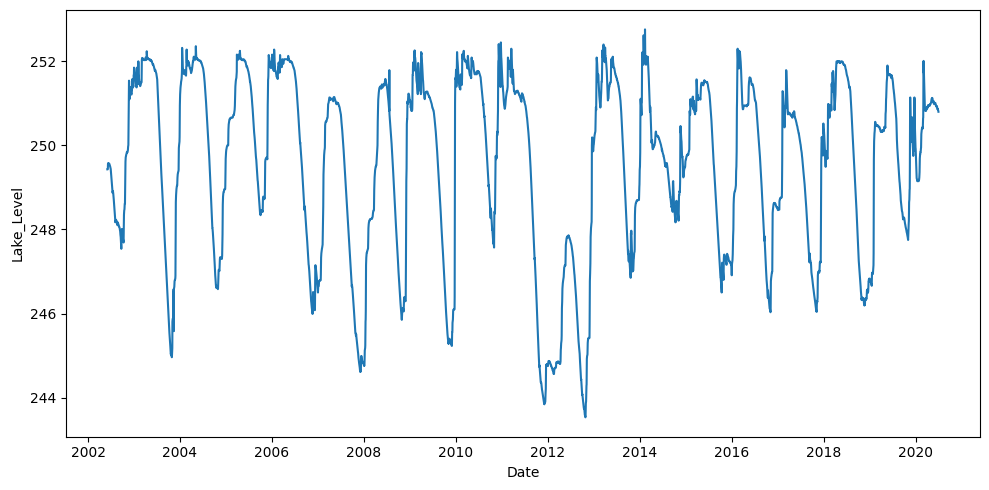

In [37]:

import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)

plt.tight_layout()

plt.show()

#### Descoposición de la serie

In [38]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(final_data, period = 365)
decomposition

#### ¿Cuál es la tendencia?

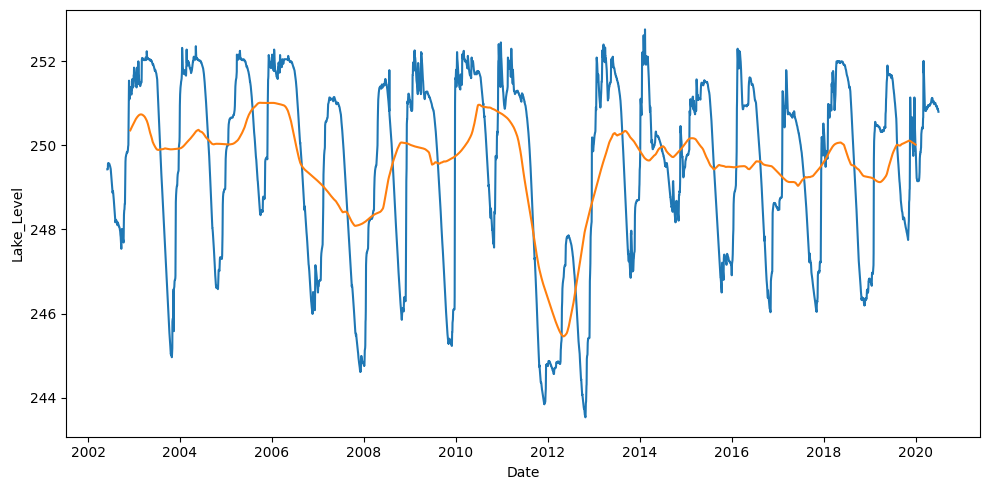

In [39]:
# Análisis de la tendencia

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

#### ¿Es estacionaria?

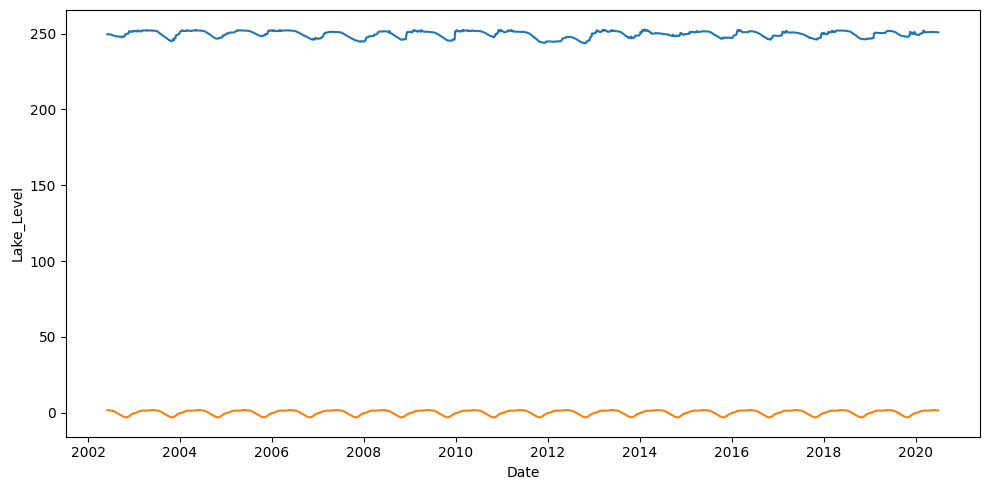

In [40]:
# Análisis de la estacionalidad

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [41]:
# Prueba de Dickey-Fuller (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(final_data)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -6.880991e+00
p-value                        1.433634e-09
#Lags Used                     3.500000e+01
Number of Observations Used    6.567000e+03
Critical Value (1%)           -3.431346e+00
Critical Value (5%)           -2.861980e+00
Critical Value (10%)          -2.567004e+00
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

#### ¿Existe variabilidad o presencia de ruido?

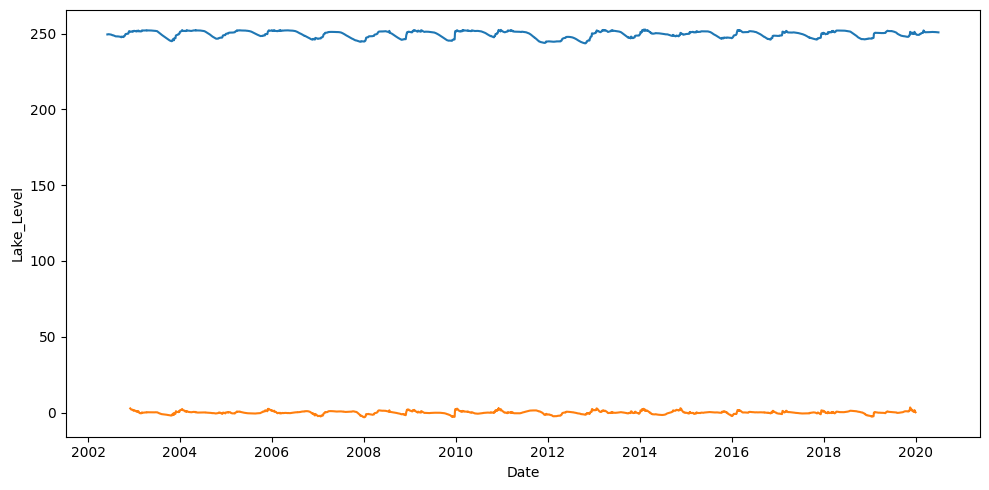

In [42]:
# Análisis de la variabilidad

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Como obserbamos, si existe variabilidad o presencia de ruido. Hay ruido en la serie, como se observa en los residuos después de la descomposición. Estas fluctuaciones no siguen una estructura clara y están centradas en cero, lo cual indica variabilidad aleatoria que no puede explicarse por la tendencia ni por un patrón estacional.

#### Análisis de la autocorrelación

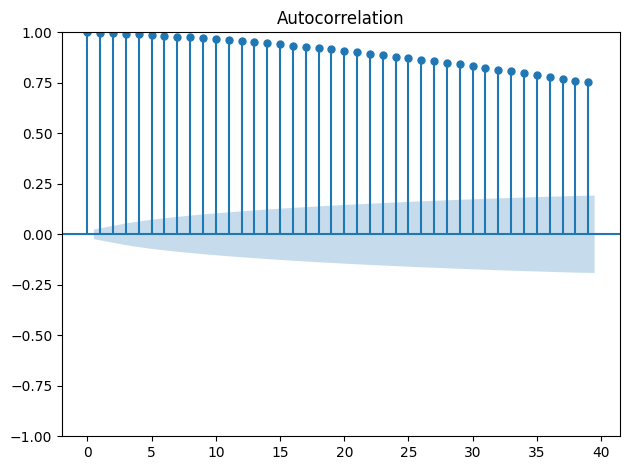

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(final_data)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye poco a poco a lo largo del tiempo.

### Paso 3: Entrena un ARIMA

In [44]:
final_data_stationary = final_data.diff().dropna()

test_stationarity(final_data_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -1.086506e+01
p-value                        1.414384e-19
#Lags Used                     2.600000e+01
Number of Observations Used    6.575000e+03
Critical Value (1%)           -3.431345e+00
Critical Value (5%)           -2.861980e+00
Critical Value (10%)          -2.567004e+00
dtype: float64

In [45]:
from pmdarima import auto_arima

model = auto_arima(final_data_stationary, seasonal=False, trace=True, m = 365) # El parametro 'm' se ignora si 'seasonal' = False. 

Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/l

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12554.732, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11120.409, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12471.594, Time=0.10 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12132.622, Time=0.19 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12563.107, Time=0.48 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-12397.690, Time=0.27 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12556.334, Time=0.53 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-12600.109, Time=0.71 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-12481.928, Time=0.35 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-12620.761, Time=1.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-12618.770, Time=1.40 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-12618.558, Time=1.43 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-12618.669, Time=1.31 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-12620.863, Time=1.05 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-12620.859, Time=0.87 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-12620.999, Time=1.14 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-12620.881, Time=1.07 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-12619.670, Time=1.57 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-12617.974, Time=1.32 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-12577.544, Time=1.33 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0]             : AIC=-12615.908, Time=1.11 sec


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-12578.710, Time=1.98 sec

Best model:  ARIMA(4,0,2)(0,0,0)[0]          
Total fit time: 19.907 seconds


In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6602
Model:               SARIMAX(4, 0, 2)   Log Likelihood                6317.499
Date:                Thu, 10 Apr 2025   AIC                         -12620.999
Time:                        11:24:51   BIC                         -12573.433
Sample:                    06-04-2002   HQIC                        -12604.560
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3901      0.078      4.974      0.000       0.236       0.544
ar.L2          0.9329      0.099      9.450      0.000       0.739       1.126
ar.L3         -0.2941      0.025    -11.884      0.000      -0.343      -0.246
ar.L4         -0.0601      0.006     -9.813      0.000      -0.072      -0.048
ma.L1         -0.0206      0.078     -0.263      0.793      -0.174       0.133
ma.L2         -0.8636      0.069    -12.433      0.000      -1.000      -0.727
sigma2         0.0086   2.48e-05    348.824      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2214727.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             5.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Paso 4: Predice con el conjunto de test

In [47]:
# Predicción del modelo

forecast = model.predict(365)
forecast

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2020-07-01   -1.004093e-02
2020-07-02   -6.885456e-03
2020-07-03   -5.568556e-03
2020-07-04   -4.439250e-03
2020-07-05   -4.297254e-03
                  ...     
2021-06-26   -2.155483e-07
2021-06-27   -2.096997e-07
2021-06-28   -2.040097e-07
2021-06-29   -1.984742e-07
2021-06-30   -1.930888e-07
Freq: D, Length: 365, dtype: float64

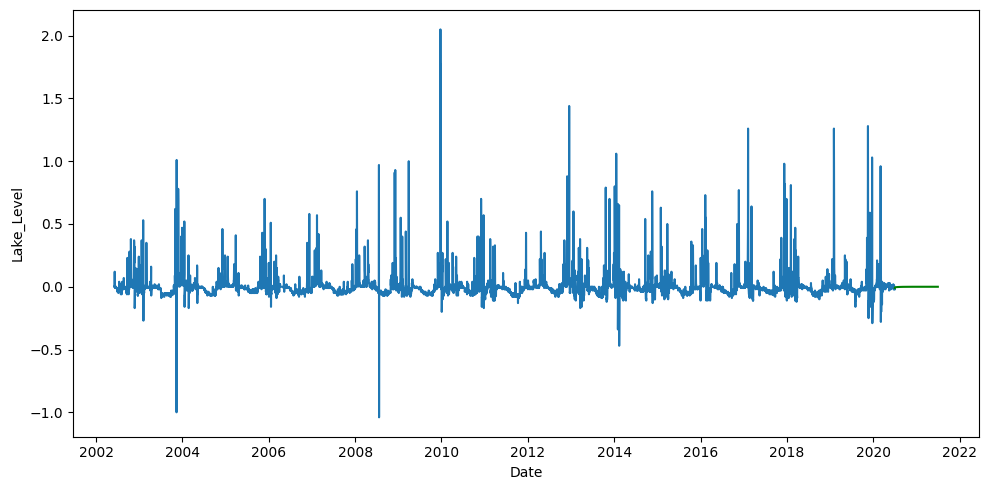

In [48]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = final_data_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

#### Guardar el modelo

In [49]:
with open("/Users/julian/Desktop/vs code/Sistema_de_detección_de_agua_Project_24_Julian_Lopez/Sistema_de_deteccion_de_agua_Project_24_Julian_Lopez/models/Model_auto_arima.pkl", "wb") as file:
  pickle.dump(model, file)